In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
import os
import logging
from datetime import datetime
import warnings
from tqdm import tqdm

# Thiết lập logging
logging.basicConfig(
    filename='classical_models_log.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Tắt cảnh báo không cần thiết
warnings.filterwarnings("ignore")

# Tham số cấu hình
CONFIG = {
    'forecast_horizon': 12,  # Số tháng dự báo
    'seasonal_periods': 12,  # Chu kỳ mùa vụ (hàng năm)
    'min_data_length': 24,  # Độ dài tối thiểu của dữ liệu
    'img_dir': 'plots',  # Thư mục lưu biểu đồ
    'results_file': 'classical_model_results.csv',  # File lưu kết quả
}

# Hàm kiểm tra dữ liệu đầu vào
def validate_input_data(df, required_columns):
    """Kiểm tra tính hợp lệ của dữ liệu đầu vào."""
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Thiếu các cột bắt buộc: {required_columns}")
    if df.index.duplicated().any():
        raise ValueError("Index chứa giá trị trùng lặp!")
    if not df.index.is_monotonic_increasing:
        raise ValueError("Index không được sắp xếp tăng dần!")
    if df[required_columns].isnull().sum().any():
        raise ValueError(f"Dữ liệu chứa giá trị thiếu: {df[required_columns].isnull().sum().to_dict()}")
    if df[required_columns].replace([np.inf, -np.inf], np.nan).isnull().sum().any():
        raise ValueError("Dữ liệu chứa giá trị vô cực!")
    # Kiểm tra dữ liệu số
    if not all(df[required_columns].dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("Một số cột không phải kiểu số!")

# Hàm kiểm tra tính dừng
def check_stationarity(series, name):
    """Kiểm tra tính dừng bằng ADF test và trả về bậc sai phân cần thiết."""
    max_diff = 2
    series_clean = series.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    if len(series_clean) < 2:
        logger.error(f"{name}: Dữ liệu quá ngắn sau khi làm sạch!")
        return 0
    d = 0
    while d <= max_diff:
        result = adfuller(series_clean)
        logger.info(f"ADF Test for {name} (d={d}): Statistic={result[0]:.4f}, p-value={result[1]:.4f}")
        if result[1] < 0.05:
            logger.info(f"{name} dừng ở bậc sai phân d={d}")
            return d
        if d == max_diff:
            logger.warning(f"{name} vẫn không dừng sau {max_diff} lần sai phân. Dùng d={d}.")
            return d
        series_clean = series_clean.diff().dropna()
        if len(series_clean) < 2:
            logger.warning(f"{name}: Dữ liệu quá ngắn sau sai phân {d+1}!")
            return d
        d += 1
    return d

# Hàm tính toán các chỉ số đánh giá
def calculate_metrics(actual, predicted):
    """Tính RMSE, MAE, MAPE, sMAPE."""
    actual = np.array(actual, dtype=float)
    predicted = np.array(predicted, dtype=float)
    
    # Kiểm tra NaN hoặc vô cực
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted) & ~np.isinf(actual) & ~np.isinf(predicted)
    actual = actual[valid_mask]
    predicted = predicted[valid_mask]
    
    if len(actual) == 0:
        logger.warning("Không có dữ liệu hợp lệ để tính chỉ số!")
        return np.nan, np.nan, np.nan, np.nan
    
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mae = np.mean(np.abs(predicted - actual))
    
    # Tính MAPE, bỏ qua các giá trị actual gần 0
    mape_mask = np.abs(actual) > 1e-8
    if mape_mask.sum() > 0:
        mape = np.mean(np.abs((predicted[mape_mask] - actual[mape_mask]) / actual[mape_mask])) * 100
    else:
        mape = np.nan
        logger.warning("Không thể tính MAPE: Tất cả giá trị actual quá gần 0!")
    
    smape = 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))
    return rmse, mae, mape, smape

# Hàm trực quan hóa dự báo
def plot_forecast(historical, test, forecast, forecast_index, title, ylabel, filename, confidence_intervals=None):
    """Vẽ và lưu biểu đồ dự báo với khoảng tin cậy."""
    if forecast is None or len(forecast) != len(forecast_index) or len(forecast_index) != CONFIG['forecast_horizon']:
        logger.error(f"Dữ liệu dự báo không hợp lệ: len(forecast)={len(forecast) if forecast is not None else 'None'}, len(forecast_index)={len(forecast_index)}")
        return
    
    if historical.empty or test.empty:
        logger.error(f"Dữ liệu lịch sử hoặc test rỗng: {title}")
        return
    
    plt.figure(figsize=(12, 4))
    plt.plot(historical.index, historical, label='Lịch sử', color='blue')
    plt.plot(test.index, test, label='Thực tế (Test)', color='green')
    plt.plot(forecast_index, forecast, label='Dự báo', color='orange', linestyle='--', linewidth=2)
    if confidence_intervals is not None:
        plt.fill_between(
            forecast_index,
            confidence_intervals[0],
            confidence_intervals[1],
            color='orange',
            alpha=0.2,
            label='Khoảng tin cậy 95%'
        )
    plt.title(title)
    plt.xlabel('Thời gian')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    try:
        plt.savefig(os.path.join(CONFIG['img_dir'], filename))
        logger.info(f"Đã lưu biểu đồ: {filename}")
    except Exception as e:
        logger.error(f"Lỗi khi lưu biểu đồ {filename}: {str(e)}")
    plt.close()

# Hàm trực quan hóa ACF phần dư
def plot_residual_acf(residuals, title, filename):
    """Vẽ và lưu biểu đồ ACF của phần dư."""
    if residuals is None or len(residuals) < 2:
        logger.warning(f"Bỏ qua ACF: Không đủ dữ liệu phần dư - {title}")
        return
    plt.figure(figsize=(5, 3))
    max_lags = min(20, len(residuals) - 1)
    if max_lags < 1:
        logger.warning(f"Bỏ qua ACF: Quá ít residuals - {title}")
        return
    plot_acf(residuals, lags=max_lags, title=title)
    plt.tight_layout()
    try:
        plt.savefig(os.path.join(CONFIG['img_dir'], filename))
        logger.info(f"Đã lưu biểu đồ ACF: {filename}")
    except Exception as e:
        logger.error(f"Lỗi khi lưu biểu đồ ACF {filename}: {str(e)}")
    plt.close()

# Hàm chạy Exponential Smoothing
def run_exponential_smoothing(train, test, forecast_index, seasonal_periods=CONFIG['seasonal_periods']):
    """Chạy mô hình Exponential Smoothing với khoảng tin cậy."""
    try:
        logger.info(f"Chạy Exponential Smoothing: train_shape={train.shape}, test_shape={test.shape}")
        model = ExponentialSmoothing(
            train,
            trend='add',
            seasonal='add',
            seasonal_periods=seasonal_periods
        ).fit(optimized=True)
        forecast = model.forecast(CONFIG['forecast_horizon'])
        residuals = train - model.fittedvalues
        
        # Kiểm tra dự báo
        if forecast is None or len(forecast) != CONFIG['forecast_horizon'] or np.any(np.isnan(forecast)):
            logger.error(f"Dự báo Exponential Smoothing không hợp lệ: {forecast}")
            return None, None, None, None, None, None, None
        
        # Đảm bảo dự báo có đúng chỉ mục
        forecast = pd.Series(forecast.values, index=forecast_index)
        
        # Khoảng tin cậy dựa trên phần dư
        resid_std = np.std(residuals)
        ci_lower = forecast - 1.96 * resid_std
        ci_upper = forecast + 1.96 * resid_std
        
        rmse, mae, mape, smape = calculate_metrics(test, forecast)
        logger.info(f"Exponential Smoothing: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}, sMAPE={smape:.4f}")
        return forecast, residuals, rmse, mae, mape, smape, (ci_lower, ci_upper)
    except Exception as e:
        logger.error(f"Lỗi Exponential Smoothing: {str(e)}")
        return None, None, None, None, None, None, None

# Hàm chạy ARIMA
def run_arima(train, test, forecast_index, order):
    """Chạy mô hình ARIMA với khoảng tin cậy."""
    try:
        logger.info(f"Chạy ARIMA: order={order}, train_shape={train.shape}, test_shape={test.shape}")
        model = SARIMAX(
            train,
            order=order,
            enforce_stationarity=True,
            enforce_invertibility=True
        ).fit(disp=False, maxiter=200)
        forecast_results = model.get_forecast(steps=CONFIG['forecast_horizon'])
        forecast = forecast_results.predicted_mean
        ci = forecast_results.conf_int(alpha=0.05)
        residuals = model.resid
        
        # Kiểm tra dự báo
        if forecast is None or len(forecast) != CONFIG['forecast_horizon'] or np.any(np.isnan(forecast)):
            logger.error(f"Dự báo ARIMA không hợp lệ: {forecast}")
            return None, None, None, None, None, None, None
        
        # Đảm bảo dự báo có đúng chỉ mục
        forecast = pd.Series(forecast.values, index=forecast_index)
        ci_lower = pd.Series(ci.iloc[:, 0].values, index=forecast_index)
        ci_upper = pd.Series(ci.iloc[:, 1].values, index=forecast_index)
        
        rmse, mae, mape, smape = calculate_metrics(test, forecast)
        logger.info(f"ARIMA: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}, sMAPE={smape:.4f}")
        return forecast, residuals, rmse, mae, mape, smape, (ci_lower, ci_upper)
    except Exception as e:
        logger.error(f"Lỗi ARIMA: {str(e)}")
        return None, None, None, None, None, None, None

# Hàm chạy SARIMA
def run_sarima(train, test, forecast_index, order, seasonal_order):
    """Chạy mô hình SARIMA với khoảng tin cậy."""
    try:
        logger.info(f"Chạy SARIMA: order={order}, seasonal_order={seasonal_order}, train_shape={train.shape}, test_shape={test.shape}")
        model = SARIMAX(
            train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=True,
            enforce_invertibility=True
        ).fit(disp=False, maxiter=200)
        forecast_results = model.get_forecast(steps=CONFIG['forecast_horizon'])
        forecast = forecast_results.predicted_mean
        ci = forecast_results.conf_int(alpha=0.05)
        residuals = model.resid
        
        # Kiểm tra dự báo
        if forecast is None or len(forecast) != CONFIG['forecast_horizon'] or np.any(np.isnan(forecast)):
            logger.error(f"Dự báo SARIMA không hợp lệ: {forecast}")
            return None, None, None, None, None, None, None
        
        # Đảm bảo dự báo có đúng chỉ mục
        forecast = pd.Series(forecast.values, index=forecast_index)
        ci_lower = pd.Series(ci.iloc[:, 0].values, index=forecast_index)
        ci_upper = pd.Series(ci.iloc[:, 1].values, index=forecast_index)
        
        rmse, mae, mape, smape = calculate_metrics(test, forecast)
        logger.info(f"SARIMA: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}, sMAPE={smape:.4f}")
        return forecast, residuals, rmse, mae, mape, smape, (ci_lower, ci_upper)
    except Exception as e:
        logger.error(f"Lỗi SARIMA: {str(e)}")
        return None, None, None, None, None, None, None

# Hàm chạy SARIMAX
def run_sarimax(train, test, exog_train, exog_test, forecast_index, order, seasonal_order):
    """Chạy mô hình SARIMAX với khoảng tin cậy."""
    try:
        logger.info(f"Chạy SARIMAX: order={order}, seasonal_order={seasonal_order}, train_shape={train.shape}, exog_train_shape={exog_train.shape}")
        if not all(exog_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
            raise ValueError("exog_train chứa cột không phải kiểu số!")
        if not all(exog_test.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
            raise ValueError("exog_test chứa cột không phải kiểu số!")
        if exog_train.isnull().any().any() or exog_test.isnull().any().any():
            raise ValueError(f"exog chứa NaN: exog_train={exog_train.isnull().sum().to_dict()}, exog_test={exog_test.isnull().sum().to_dict()}")
        
        model = SARIMAX(
            train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=True,
            enforce_invertibility=True
        ).fit(disp=False, maxiter=200)
        forecast_results = model.get_forecast(steps=CONFIG['forecast_horizon'], exog=exog_test)
        forecast = forecast_results.predicted_mean
        ci = forecast_results.conf_int(alpha=0.05)
        residuals = model.resid
        
        # Kiểm tra dự báo
        if forecast is None or len(forecast) != CONFIG['forecast_horizon'] or np.any(np.isnan(forecast)):
            logger.error(f"Dự báo SARIMAX không hợp lệ: {forecast}")
            return None, None, None, None, None, None, None
        
        # Đảm bảo dự báo có đúng chỉ mục
        forecast = pd.Series(forecast.values, index=forecast_index)
        ci_lower = pd.Series(ci.iloc[:, 0].values, index=forecast_index)
        ci_upper = pd.Series(ci.iloc[:, 1].values, index=forecast_index)
        
        rmse, mae, mape, smape = calculate_metrics(test, forecast)
        logger.info(f"SARIMAX: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}, sMAPE={smape:.4f}")
        return forecast, residuals, rmse, mae, mape, smape, (ci_lower, ci_upper)
    except Exception as e:
        logger.error(f"Lỗi SARIMAX: {str(e)}")
        return None, None, None, None, None, None, None

# Hàm chạy Prophet
def run_prophet(df_prophet, test, df, forecast_index, regressors):
    """Chạy mô hình Prophet với khoảng tin cậy."""
    try:
        logger.info(f"Chạy Prophet: df_prophet_shape={df_prophet.shape}, test_shape={test.shape}")
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='additive',
            interval_width=0.95
        )
        for reg in regressors:
            model.add_regressor(reg, standardize=True)
        
        model.fit(df_prophet[:-CONFIG['forecast_horizon']])
        
        # Chuẩn bị dữ liệu tương lai
        future = model.make_future_dataframe(periods=CONFIG['forecast_horizon'], freq='MS')
        future = future.merge(
            df[regressors].reset_index(),
            left_on='ds',
            right_on=df.index.name,
            how='left'
        )
        # Đảm bảo future có DatetimeIndex trước khi nội suy
        future.set_index('ds', inplace=True)
        future[regressors] = future[regressors].interpolate(method='time')
        if future[regressors].isnull().any().any():
            logger.warning("Vẫn còn giá trị thiếu sau nội suy, điền bằng giá trị gần nhất.")
            future[regressors] = future[regressors].fillna(method='ffill').fillna(method='bfill')
        future.reset_index(inplace=True)
        
        forecast = model.predict(future)
        forecast_test = forecast.tail(CONFIG['forecast_horizon'])['yhat']
        ci_lower = forecast.tail(CONFIG['forecast_horizon'])['yhat_lower']
        ci_upper = forecast.tail(CONFIG['forecast_horizon'])['yhat_upper']
        train_forecast = model.predict(df_prophet[:-CONFIG['forecast_horizon']])['yhat']
        residuals = df_prophet[:-CONFIG['forecast_horizon']]['y'] - train_forecast
        
        # Kiểm tra dự báo
        if forecast_test is None or len(forecast_test) != CONFIG['forecast_horizon'] or np.any(np.isnan(forecast_test)):
            logger.error(f"Dự báo Prophet không hợp lệ: {forecast_test}")
            return None, None, None, None, None, None, None
        
        # Đảm bảo dự báo có đúng chỉ mục
        forecast_test = pd.Series(forecast_test.values, index=forecast_index)
        ci_lower = pd.Series(ci_lower.values, index=forecast_index)
        ci_upper = pd.Series(ci_upper.values, index=forecast_index)
        
        rmse, mae, mape, smape = calculate_metrics(test, forecast_test)
        logger.info(f"Prophet: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}, sMAPE={smape:.4f}")
        return forecast_test, residuals, rmse, mae, mape, smape, (ci_lower, ci_upper)
    except Exception as e:
        logger.error(f"Lỗi Prophet: {str(e)}")
        return None, None, None, None, None, None, None

# Hàm chính
def main():
    # Tạo thư mục lưu biểu đồ
    os.makedirs(CONFIG['img_dir'], exist_ok=True)
    
    # Đọc dữ liệu
    file_path = "data/analyzed_time_series.csv"
    if not os.path.exists(file_path):
        logger.error(f"File {file_path} không tồn tại!")
        raise FileNotFoundError(f"File {file_path} không tồn tại!")
    
    try:
        df = pd.read_csv(file_path)
        df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='coerce')
        if df['time'].isna().any():
            logger.warning("Có giá trị thời gian không hợp lệ, loại bỏ...")
            df = df.dropna(subset=['time'])
        
        df = df.sort_values(by='time')
        df.set_index('time', inplace=True)
        if not df.index.inferred_freq:
            logger.error("Không thể suy ra tần suất thời gian!")
            raise ValueError("Dữ liệu không có tần suất thời gian hợp lệ!")
        df.index.freq = 'MS'
    except Exception as e:
        logger.error(f"Lỗi khi đọc dữ liệu: {str(e)}")
        raise
    
    # Kiểm tra cột cần thiết
    required_columns = ['cpi_mom', 'cpi_yoy', 'oil_price']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        logger.error(f"Thiếu các cột: {missing_columns}")
        raise ValueError(f"Thiếu các cột: {missing_columns}")
    
    # Kiểm tra độ dài dữ liệu
    if len(df) < CONFIG['min_data_length']:
        logger.error(f"Dữ liệu quá ngắn, cần ít nhất {CONFIG['min_data_length']} tháng!")
        raise ValueError(f"Dữ liệu quá ngắn, cần ít nhất {CONFIG['min_data_length']} tháng!")
    
    # Kiểm tra và nội suy giá trị thiếu
    missing_values = df[required_columns].isnull().sum()
    if missing_values.any():
        logger.warning(f"Giá trị thiếu: {missing_values.to_dict()}")
        df[required_columns] = df[required_columns].interpolate(method='time')
        if df[required_columns].isnull().any():
            logger.error("Không thể nội suy hoàn toàn giá trị thiếu!")
            raise ValueError("Không thể nội suy hoàn toàn giá trị thiếu!")
    
    # Kiểm tra dữ liệu đầu vào
    validate_input_data(df, required_columns)
    
    # Kiểm tra tính dừng và điều chỉnh dữ liệu
    d_mom = check_stationarity(df['cpi_mom'], 'CPI MoM')
    d_yoy = check_stationarity(df['cpi_yoy'], 'CPI YoY')
    
    # Chia tập train/test
    train_mom, test_mom = df['cpi_mom'][:-CONFIG['forecast_horizon']], df['cpi_mom'][-CONFIG['forecast_horizon']:]
    train_yoy, test_yoy = df['cpi_yoy'][:-CONFIG['forecast_horizon']], df['cpi_yoy'][-CONFIG['forecast_horizon']:]
    exog_train = df[['oil_price']][:-CONFIG['forecast_horizon']].copy()
    exog_test = df[['oil_price']][-CONFIG['forecast_horizon']:].copy()
    
    # Kiểm tra NaN trong train/test/exog
    if train_mom.isnull().any() or test_mom.isnull().any() or train_yoy.isnull().any() or test_yoy.isnull().any():
        logger.error(f"NaN trong dữ liệu: train_mom={train_mom.isnull().sum()}, test_mom={test_mom.isnull().sum()}, train_yoy={train_yoy.isnull().sum()}, test_yoy={test_yoy.isnull().sum()}")
        raise ValueError("Dữ liệu train/test chứa NaN!")
    if exog_train.isnull().any().any() or exog_test.isnull().any().any():
        logger.error(f"NaN trong exog: exog_train={exog_train.isnull().sum().to_dict()}, exog_test={exog_test.isnull().sum().to_dict()}")
        raise ValueError("Dữ liệu exog chứa NaN!")
    
    # In dữ liệu để debug
    logger.info(f"Train MoM đầu: {train_mom.head()}")
    logger.info(f"Train MoM cuối: {train_mom.tail()}")
    logger.info(f"Test MoM: {test_mom}")
    logger.info(f"Exog Train: {exog_train.tail()}")
    logger.info(f"Exog Test: {exog_test}")
    
    # Tạo chỉ mục dự báo
    last_date = df.index[-1]
    forecast_index = pd.date_range(
        start=last_date + pd.offsets.MonthBegin(1),
        periods=CONFIG['forecast_horizon'],
        freq='MS'
    )
    
    # Chuẩn bị dữ liệu cho Prophet
    df_prophet_mom = pd.DataFrame({
        'ds': df.index,
        'y': df['cpi_mom'].clip(lower=1e-6),
        'oil_price': df['oil_price']
    }).reset_index(drop=True)
    
    df_prophet_yoy = pd.DataFrame({
        'ds': df.index,
        'y': df['cpi_yoy'].clip(lower=1e-6),
        'oil_price': df['oil_price']
    }).reset_index(drop=True)
    
    # Danh sách mô hình và tham số
    models = [
        ('Exponential Smoothing', run_exponential_smoothing, {
            'mom': {'seasonal_periods': CONFIG['seasonal_periods']},
            'yoy': {'seasonal_periods': CONFIG['seasonal_periods']}
        }),
        ('ARIMA', run_arima, {
            'mom': {'order': (1, d_mom, 1)},
            'yoy': {'order': (1, d_yoy, 1)}
        }),
        ('SARIMA', run_sarima, {
            'mom': {'order': (1, d_mom, 1), 'seasonal_order': (1, 0, 1, CONFIG['seasonal_periods'])},
            'yoy': {'order': (1, d_yoy, 1), 'seasonal_order': (1, 0, 1, CONFIG['seasonal_periods'])}
        }),
        ('SARIMAX', run_sarimax, {
            'mom': {'order': (1, d_mom, 1), 'seasonal_order': (1, 0, 1, CONFIG['seasonal_periods'])},
            'yoy': {'order': (1, d_yoy, 1), 'seasonal_order': (1, 0, 1, CONFIG['seasonal_periods'])}
        }),
        ('Prophet', run_prophet, {
            'mom': {'regressors': ['oil_price']},
            'yoy': {'regressors': ['oil_price']}
        })
    ]
    
    # Chạy mô hình và lưu kết quả
    results = {'mom': {}, 'yoy': {}}
    metric_records = []
    forecast_records = []
    
    for model_name, model_func, params in tqdm(models, desc="Chạy các mô hình"):
        for target, train, test in [('mom', train_mom, test_mom), ('yoy', train_yoy, test_yoy)]:
            logger.info(f"Chạy {model_name} cho CPI {target.upper()}")
            try:
                if model_name == 'Prophet':
                    forecast, residuals, rmse, mae, mape, smape, ci = model_func(
                        df_prophet_mom if target == 'mom' else df_prophet_yoy,
                        test,
                        df,
                        forecast_index,
                        params[target]['regressors']
                    )
                else:
                    if 'SARIMAX' in model_name:
                        args = [train, test, exog_train, exog_test, forecast_index]
                    else:
                        args = [train, test, forecast_index]
                    forecast, residuals, rmse, mae, mape, smape, ci = model_func(
                        *args, **params[target]
                    )
                
                if forecast is None:
                    logger.error(f"Không tạo được dự báo cho {model_name} với {target.upper()}")
                    continue
                
                # Debug dữ liệu dự báo
                logger.info(f"Dữ liệu dự báo {model_name} cho {target.upper()}: {forecast[:5]}")
                
                results[target][model_name] = {
                    'forecast': forecast,
                    'residuals': residuals,
                    'rmse': rmse,
                    'mae': mae,
                    'mape': mape,
                    'smape': smape,
                    'confidence_intervals': ci
                }
                
                # Lưu dự báo
                forecast_series = results[target][model_name]['forecast']
                logger.info(f"Forecast series cho {model_name} {target.upper()}: {forecast_series.head()}")
                if forecast_series.isnull().any():
                    logger.warning(f"Forecast series chứa NaN cho {model_name} {target.upper()}: {forecast_series}")
                    continue
                for date, value in forecast_series.items():
                    forecast_records.append({
                        'Model': model_name,
                        'Target': f'CPI_{target.upper()}',
                        'Date': date,
                        'Forecast': float(value)  # Đảm bảo giá trị là số thực
                    })
                
                # Trực quan hóa
                plot_forecast(
                    df[f'cpi_{target}'],
                    test,
                    results[target][model_name]['forecast'],
                    forecast_index,
                    f'CPI {target.upper()}: Lịch sử, Thực tế, và Dự báo {model_name}',
                    'Giá trị',
                    f'cpi_{target}_{model_name.lower().replace(" ", "_")}_forecast.png',
                    confidence_intervals=ci
                )
                
                plot_residual_acf(
                    residuals,
                    f'ACF Phần dư {model_name} CPI {target.upper()}',
                    f'residual_acf_{model_name.lower().replace(" ", "_")}_{target}.png'
                )
                
                # Lưu số liệu
                metric_records.extend([
                    {'Model': model_name, 'Metric': 'RMSE', f'CPI_{target.upper()}': rmse},
                    {'Model': model_name, 'Metric': 'MAE', f'CPI_{target.upper()}': mae},
                    {'Model': model_name, 'Metric': 'MAPE', f'CPI_{target.upper()}': mape},
                    {'Model': model_name, 'Metric': 'sMAPE', f'CPI_{target.upper()}': smape}
                ])
                
            except Exception as e:
                logger.error(f"Lỗi khi chạy {model_name} cho {target.upper()}: {str(e)}")
                continue
    
    # Lưu kết quả
    if metric_records:
        results_df = pd.DataFrame(metric_records)
        results_df = results_df.pivot_table(
            index='Model',
            columns='Metric',
            values=['CPI_MOM', 'CPI_YOY'],
            aggfunc='max'
        ).reset_index()
        results_df.columns = ['Model'] + [f"{col[1]}_{col[0]}" for col in results_df.columns[1:]]
        try:
            results_df.to_csv(CONFIG['results_file'], index=False)
            logger.info(f"Kết quả đã được lưu vào {CONFIG['results_file']}")
        except Exception as e:
            logger.error(f"Lỗi khi lưu kết quả: {str(e)}")
            raise
    
    # Lưu dự báo
    if forecast_records:
        forecast_df = pd.DataFrame(forecast_records)
        try:
            forecast_df.to_csv('classical_model_forecasts.csv', index=False)
            logger.info("Dự báo đã được lưu vào classical_model_forecasts.csv")
        except Exception as e:
            logger.error(f"Lỗi khi lưu dự báo: {str(e)}")
            raise
    else:
        logger.error("Không có dự báo nào được lưu vào forecast_records!")
    
    # In kết quả
    for metric in ['RMSE', 'MAE', 'MAPE', 'sMAPE']:
        logger.info(f"\nKết quả {metric}:")
        for model_name in results['mom']:
            if model_name in results['mom'] and results['mom'][model_name].get('rmse'):
                logger.info(f"{model_name} CPI MOM: {results['mom'][model_name][metric.lower()]:.4f}")
            if model_name in results['yoy'] and results['yoy'][model_name].get('rmse'):
                logger.info(f"{model_name} CPI YOY: {results['yoy'][model_name][metric.lower()]:.4f}")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        logger.error(f"Lỗi chương trình chính: {str(e)}")
        raise

Chạy các mô hình:  80%|████████  | 4/5 [00:08<00:02,  2.64s/it]22:52:01 - cmdstanpy - INFO - Chain [1] start processing
22:52:01 - cmdstanpy - INFO - Chain [1] done processing
22:52:02 - cmdstanpy - INFO - Chain [1] start processing
22:52:02 - cmdstanpy - INFO - Chain [1] done processing
Chạy các mô hình: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

Loading data...
Data loaded successfully.
Dataset shape: (349, 17)

First few rows:
            cpi_mom  cpi_yoy  oil_price  gold_price  interest_rate  \
time                                                                 
1995-12-01    100.3   112.91      19.55       388.1            NaN   
1996-01-01    100.9   109.76      17.74       408.5            NaN   
1996-02-01    102.5   108.80      19.54       401.2            NaN   
1996-03-01    100.8   109.46      21.47       398.4            NaN   
1996-04-01    100.1   108.48      21.20       393.5          25.41   

            cpi_mom_smoothed  cpi_yoy_smoothed  cpi_mom_log  cpi_yoy_log  \
time                                                                       
1995-12-01        100.300000        112.910000     4.608166     4.726591   
1996-01-01        101.233333        110.490000     4.614130     4.698296   
1996-02-01        101.400000        109.340000     4.629863     4.689511   
1996-03-01        101.133333        108.91333

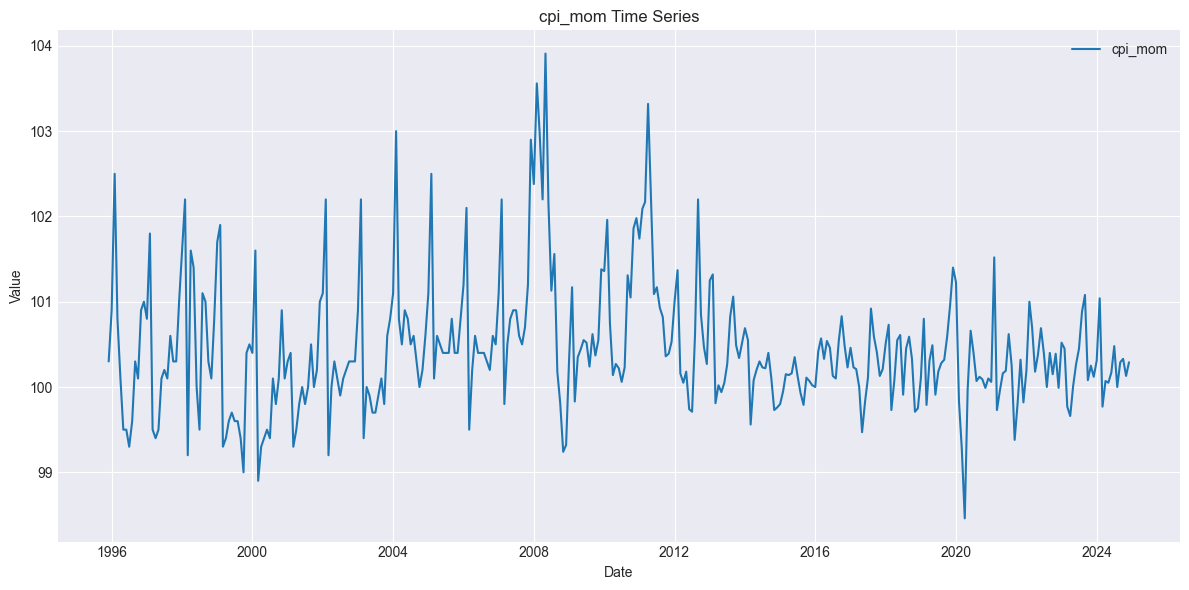

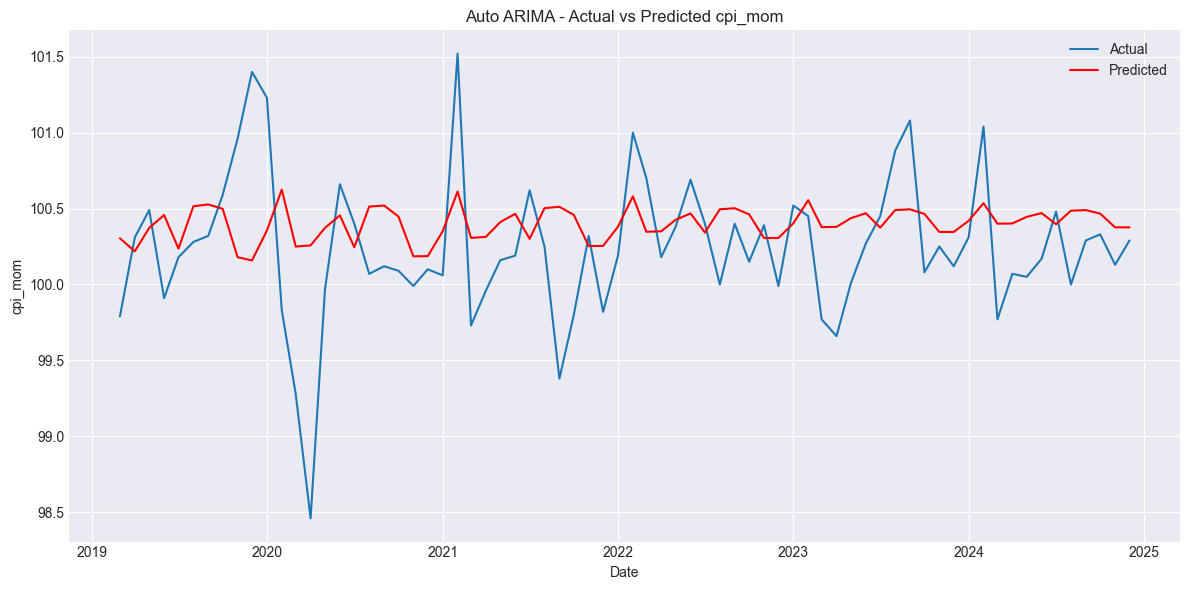

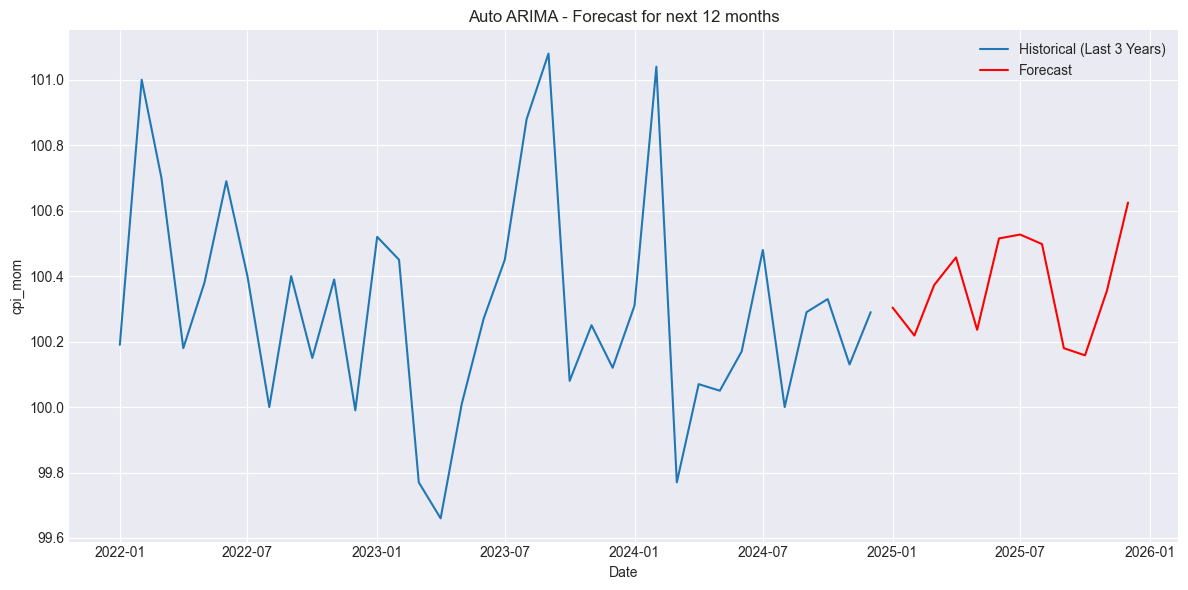

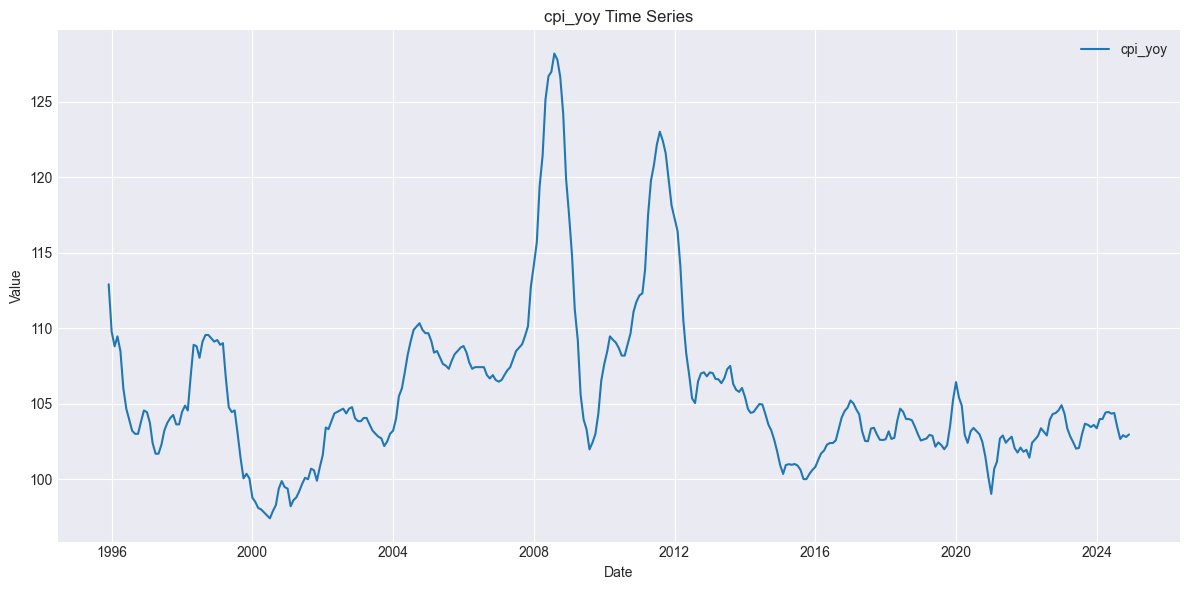

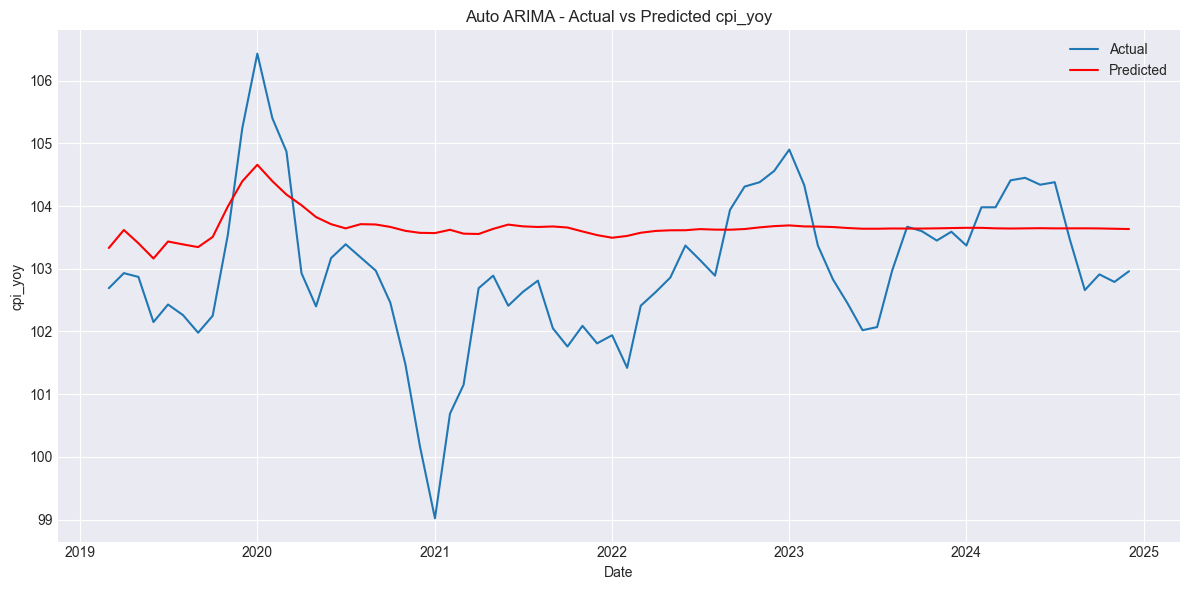

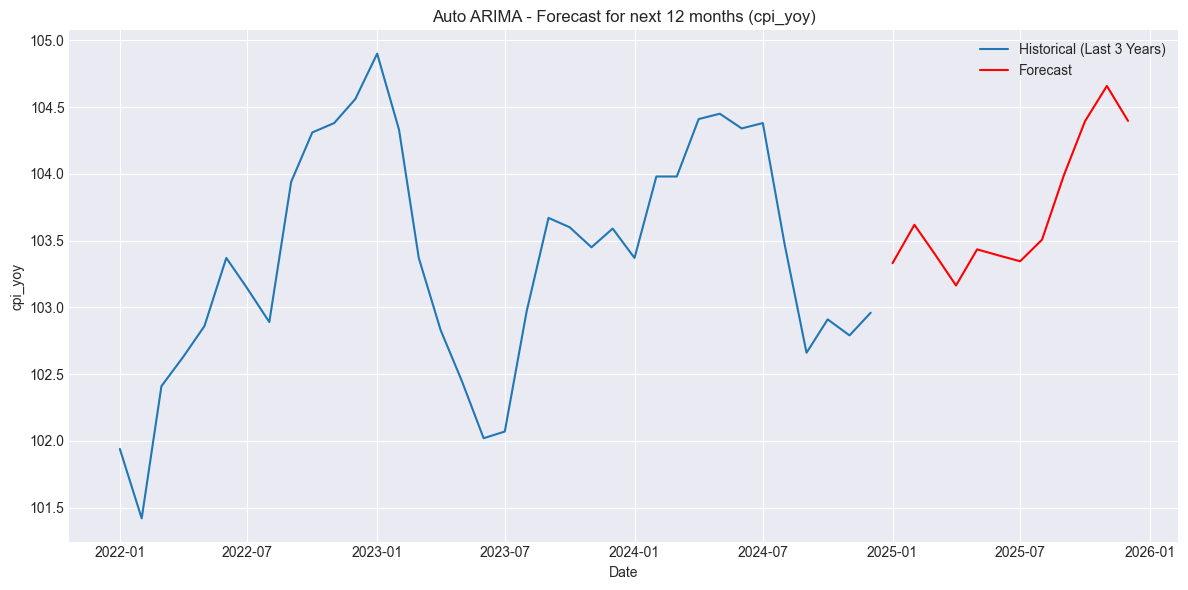

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

# Load the data
print("Loading data...")
try:
    data = pd.read_csv('data/analyzed_time_series.csv')
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    exit(1)

# Convert time column to datetime
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Display basic information about the dataset
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
print(data.head())

# Check for missing values
print("\nMissing values in key columns:")
print(data[['cpi_mom', 'cpi_yoy']].isnull().sum())

# Select the target variable for ARIMA modeling
target = 'cpi_mom'
series = data[target].dropna()

print(f"\nModeling target variable: {target}")
print(f"Series length: {len(series)}")

# Plot the CPI data
plt.figure(figsize=(12, 6))
plt.plot(series, label=f'{target}')
plt.title(f'{target} Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.savefig(f'plots/{target}_time_series.png')
print(f"Saved plot to {target}_time_series.png")

# Split the data into training and testing sets
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
print(f"\nTraining data size: {len(train)}")
print(f"Testing data size: {len(test)}")
print(f"Training period: {train.index.min()} to {train.index.max()}")
print(f"Testing period: {test.index.min()} to {test.index.max()}")

# Use auto_arima to automatically find the best ARIMA model
print("\nFinding the best ARIMA model using auto_arima...")
print("This may take a few minutes...")

try:
    auto_model = auto_arima(
        train,
        start_p=0, start_q=0,
        max_p=5, max_q=5, max_d=2,
        seasonal=True,  # Consider seasonal effects
        m=12,  # Monthly data
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        information_criterion='aic'
    )
    
    print("\nBest model summary:")
    print(auto_model.summary())
    print(f"Best ARIMA order: {auto_model.order}")
    if hasattr(auto_model, 'seasonal_order'):
        print(f"Best seasonal order: {auto_model.seasonal_order}")
    
    # Make predictions on the test set
    print("\nMaking predictions on test data...")
    predictions = auto_model.predict(n_periods=len(test))
    
    # Calculate error metrics
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, predictions)
    
    print(f"\nTest set metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, predictions, label='Predicted', color='red')
    plt.title(f'Auto ARIMA - Actual vs Predicted {target}')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/auto_arima_predictions.png')
    print("Saved predictions plot to auto_arima_predictions.png")
    
    # Forecast future values (next 12 months)
    forecast_steps = 12
    print(f"\nForecasting next {forecast_steps} months...")
    forecast = auto_model.predict(n_periods=forecast_steps)
    
    # Create forecast dates
    last_date = series.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(series.index[-36:], series[-36:], label='Historical (Last 3 Years)')
    plt.plot(forecast_dates, forecast, label='Forecast', color='red')
    plt.title(f'Auto ARIMA - Forecast for next {forecast_steps} months')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/auto_arima_forecast.png')
    print("Saved forecast plot to auto_arima_forecast.png")
    
    # Print forecast values
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        f'Forecasted {target}': forecast
    })
    print("\nForecast for the next 12 months:")
    print(forecast_df)
    
    # Save forecast to CSV
    forecast_df.to_csv('plots/auto_arima_forecast.csv', index=False)
    print("Saved forecast data to auto_arima_forecast.csv")
    
    # Try with Year-over-Year CPI
    target2 = 'cpi_yoy'
    series2 = data[target2].dropna()
    
    print(f"\n\nModeling second target variable: {target2}")
    print(f"Series length: {len(series2)}")
    
    # Plot the second CPI data
    plt.figure(figsize=(12, 6))
    plt.plot(series2, label=f'{target2}')
    plt.title(f'{target2} Time Series')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/{target2}_time_series.png')
    print(f"Saved plot to {target2}_time_series.png")
    
    # Split the data into training and testing sets
    train2, test2 = series2[:train_size], series2[train_size:]
    
    # Use auto_arima to automatically find the best ARIMA model
    print("\nFinding the best ARIMA model for second target...")
    auto_model2 = auto_arima(
        train2,
        start_p=0, start_q=0,
        max_p=5, max_q=5, max_d=2,
        seasonal=True,
        m=12,  # Monthly data
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        information_criterion='aic'
    )
    
    print("\nBest model summary for second target:")
    print(auto_model2.summary())
    print(f"Best ARIMA order: {auto_model2.order}")
    if hasattr(auto_model2, 'seasonal_order'):
        print(f"Best seasonal order: {auto_model2.seasonal_order}")
    
    # Make predictions on the test set
    predictions2 = auto_model2.predict(n_periods=len(test2))
    
    # Calculate error metrics
    mse2 = mean_squared_error(test2, predictions2)
    rmse2 = np.sqrt(mse2)
    mae2 = mean_absolute_error(test2, predictions2)
    
    print(f"\nTest set metrics for {target2}:")
    print(f"MSE: {mse2:.4f}")
    print(f"RMSE: {rmse2:.4f}")
    print(f"MAE: {mae2:.4f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(test2.index, test2, label='Actual')
    plt.plot(test2.index, predictions2, label='Predicted', color='red')
    plt.title(f'Auto ARIMA - Actual vs Predicted {target2}')
    plt.xlabel('Date')
    plt.ylabel(target2)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/auto_arima_predictions_{target2}.png')
    print(f"Saved predictions plot to auto_arima_predictions_{target2}.png")
    
    # Forecast future values (next 12 months)
    forecast2 = auto_model2.predict(n_periods=forecast_steps)
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(series2.index[-36:], series2[-36:], label='Historical (Last 3 Years)')
    plt.plot(forecast_dates, forecast2, label='Forecast', color='red')
    plt.title(f'Auto ARIMA - Forecast for next {forecast_steps} months ({target2})')
    plt.xlabel('Date')
    plt.ylabel(target2)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/auto_arima_forecast_{target2}.png')
    print(f"Saved forecast plot to auto_arima_forecast_{target2}.png")
    
    # Print forecast values
    forecast_df2 = pd.DataFrame({
        'Date': forecast_dates,
        f'Forecasted {target2}': forecast2
    })
    print(f"\nForecast for the next 12 months ({target2}):")
    print(forecast_df2)
    
    # Save forecast to CSV
    forecast_df2.to_csv(f'plots/auto_arima_forecast_{target2}.csv', index=False)
    print(f"Saved forecast data to auto_arima_forecast_{target2}.csv")
    
    # Combine both forecasts
    combined_forecast = pd.DataFrame({
        'Date': forecast_dates,
        f'Forecasted {target}': forecast,
        f'Forecasted {target2}': forecast2
    })
    combined_forecast.to_csv('plots/combined_arima_forecast.csv', index=False)
    print("Saved combined forecast data to combined_arima_forecast.csv")
    
    print("\nAnalysis complete. Check the generated plots and CSV files for results.")
    
except Exception as e:
    print(f"Error during model fitting or prediction: {e}")